### Imports

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import os
import datetime
from fredapi import Fred
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
import optuna
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape, mae, rmse, smape

os.environ['OMP_NUM_THREADS'] = '1'
base_dir = Path(os.getcwd()).resolve().parent
base_dir

WindowsPath('C:/Users/diogo/Desktop/ASTP')

In [40]:
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

## Leitura dos Dados

In [41]:
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

### Dados Extras

In [42]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series).rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [43]:
fred_series_metadata[0]

id                                                                 IHLIDXNSAGB
realtime_start                                                      2025-05-06
realtime_end                                                        2025-05-06
title                             Job Postings on Indeed in the United Kingdom
observation_start                                                   2020-02-01
observation_end                                                     2025-05-02
frequency                                                         Daily, 7-Day
frequency_short                                                              D
units                                                    Index Feb, 1 2020=100
units_short                                              Index Feb, 1 2020=100
seasonal_adjustment                                    Not Seasonally Adjusted
seasonal_adjustment_short                                                  NSA
last_updated                                        

In [44]:
fred_series_list[0].name
fred_series_list[0]

2020-02-01    100.00
2020-02-02     99.90
2020-02-03     99.87
2020-02-04     99.79
2020-02-05     99.73
               ...  
2025-04-28     76.42
2025-04-29     76.55
2025-04-30     76.74
2025-05-01     76.88
2025-05-02     77.05
Name: Job Postings on Indeed in the United Kingdom, Length: 1918, dtype: float64

In [45]:
len(fred_series_list)

5

#### Corrigir Nomes

In [46]:
for i in range(len(fred_series_list)):
    print(fred_series_list[i].name)

Job Postings on Indeed in the United Kingdom
Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom
Residential Property Prices for United Kingdom
Gross Domestic Product for United Kingdom
Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom


In [47]:
def gerar_nome_curto(nome_original):
    nome_original = nome_original.lower()
    nome_original = nome_original.replace("united kingdom", "uk")
    nome_original = nome_original.replace("interest rates", "interest_rates")
    nome_original = nome_original.replace("long-term government bond yields", "lt_bond_yields")
    nome_original = nome_original.replace("gross domestic product", "gdp")
    nome_original = nome_original.replace("residential property prices", "house_prices")
    nome_original = nome_original.replace("consumer price index", "cpi")
    nome_original = nome_original.replace("job postings", "job_postings")
    nome_original = nome_original.replace(":", "")
    nome_original = nome_original.replace("(", "")
    nome_original = nome_original.replace(")", "")
    nome_original = nome_original.replace(",", "")
    nome_original = nome_original.replace("-", "_")
    nome_original = nome_original.replace(" ", "_")
    return nome_original.strip("_")


In [48]:
for serie in fred_series_list:
    nome_curto = gerar_nome_curto(serie.name)
    serie.name = nome_curto
    print(serie.name)

job_postings_on_indeed_in_the_uk
interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk
house_prices_for_uk
gdp_for_uk
consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk


### Incerteza Politica

In [49]:
UKEPU = pd.read_csv("../data/UK_Daily_Policy_Data.csv")
UKEPU['observation_date'] = pd.to_datetime(UKEPU[['year', 'month', 'day']])
UKEPU.drop(columns=['day', 'month', 'year'], inplace=True)
UKEPU.set_index('observation_date', inplace=True)
UKEPU = UKEPU.squeeze()
UKEPU

observation_date
2001-01-01     50.70
2001-01-02    110.77
2001-01-03    179.41
2001-01-04    183.22
2001-01-05     89.31
               ...  
2025-03-30    583.59
2025-03-31    246.35
2025-04-01    507.40
2025-04-02    608.20
2025-04-03    417.47
Name: daily_policy_index, Length: 8859, dtype: float64

## Preparação dos dados

In [50]:
scaler = MinMaxScaler()
seq_length = 30

# Dicionários para guardar os dados de cada série
datasets = {}

for series in fred_series_list:
    series = series.dropna()  # remove valores nulos
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    # Criar sequências
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)
    
    X, y = create_sequences(scaled_data, seq_length)

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Guardar os dados para esta série
    datasets[series.name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }


In [51]:
datasets[fred_series_list[1].name]

{'X_train': array([[[0.31744634],
         [0.32178592],
         [0.33356478],
         ...,
         [0.37634062],
         [0.37634062],
         [0.37076116]],
 
        [[0.32178592],
         [0.33356478],
         [0.3385243 ],
         ...,
         [0.37634062],
         [0.37076116],
         [0.34720345]],
 
        [[0.33356478],
         [0.3385243 ],
         [0.33976417],
         ...,
         [0.37076116],
         [0.34720345],
         [0.3354246 ]],
 
        ...,
 
        [[0.22799524],
         [0.23514934],
         [0.23886278],
         ...,
         [0.13103046],
         [0.12413053],
         [0.10738596]],
 
        [[0.23514934],
         [0.23886278],
         [0.24066681],
         ...,
         [0.12413053],
         [0.10738596],
         [0.0967354 ]],
 
        [[0.23886278],
         [0.24066681],
         [0.24123715],
         ...,
         [0.10738596],
         [0.0967354 ],
         [0.08945111]]]),
 'X_test': array([[[0.24066681],
         [0

In [52]:
# Definir função para criar sequências de dados (janelas deslizantes)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Normalizar os dados para ficar entre 0 e 1
scaler = MinMaxScaler()
UKEPU_scaled = scaler.fit_transform(UKEPU.to_frame())
UKEPU = pd.Series(UKEPU_scaled.flatten(), index=UKEPU.index)

# Definir tamanho da sequência (ex: usar 30 dias passados para prever o próximo valor)
seq_length = 30
X, y = create_sequences(UKEPU, seq_length)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Aplicação dos modelos e comparação dos packages

### Tensorflow - CNN

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW, Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.losses import Huber
from datetime import datetime


🔄 A treinar modelo para: job_postings_on_indeed_in_the_uk


c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
✅ MSE: 230.3424 | MAE: 13.2349 | RMSE: 15.1770 | MAPE: 13.98%


C:\Users\diogo\AppData\Local\Temp\ipykernel_27328\729154498.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


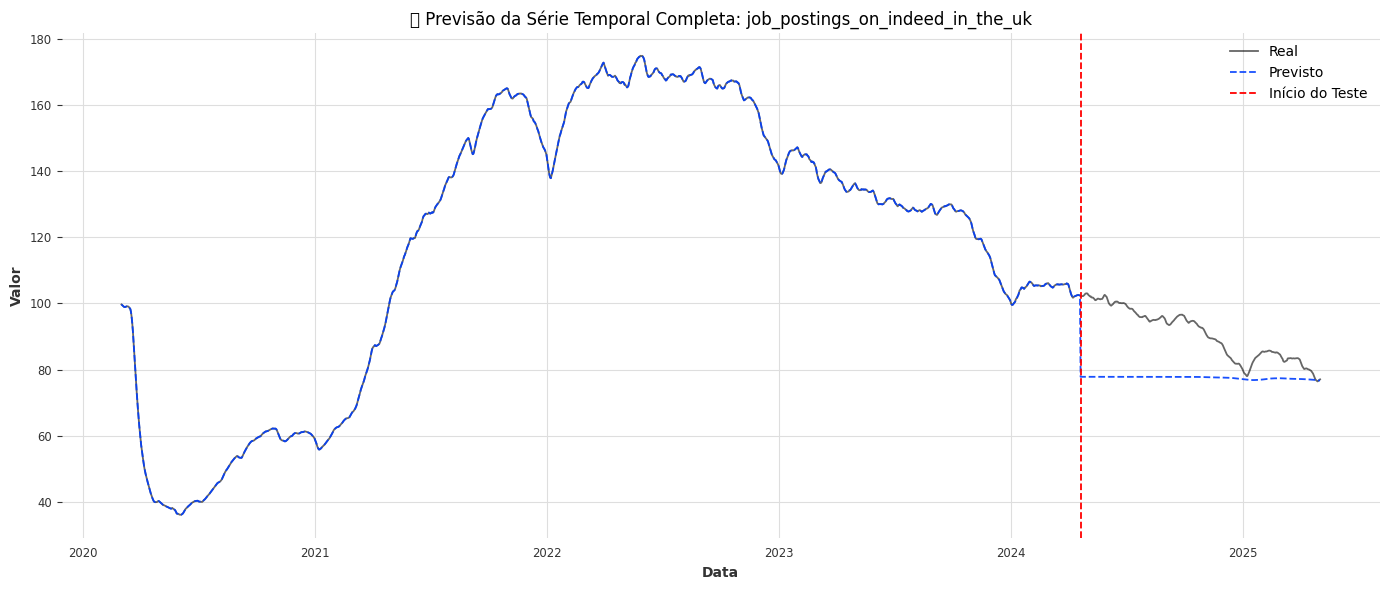


🔄 A treinar modelo para: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk


c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
✅ MSE: 1.7937 | MAE: 1.1840 | RMSE: 1.3393 | MAPE: 123.24%


C:\Users\diogo\AppData\Local\Temp\ipykernel_27328\729154498.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


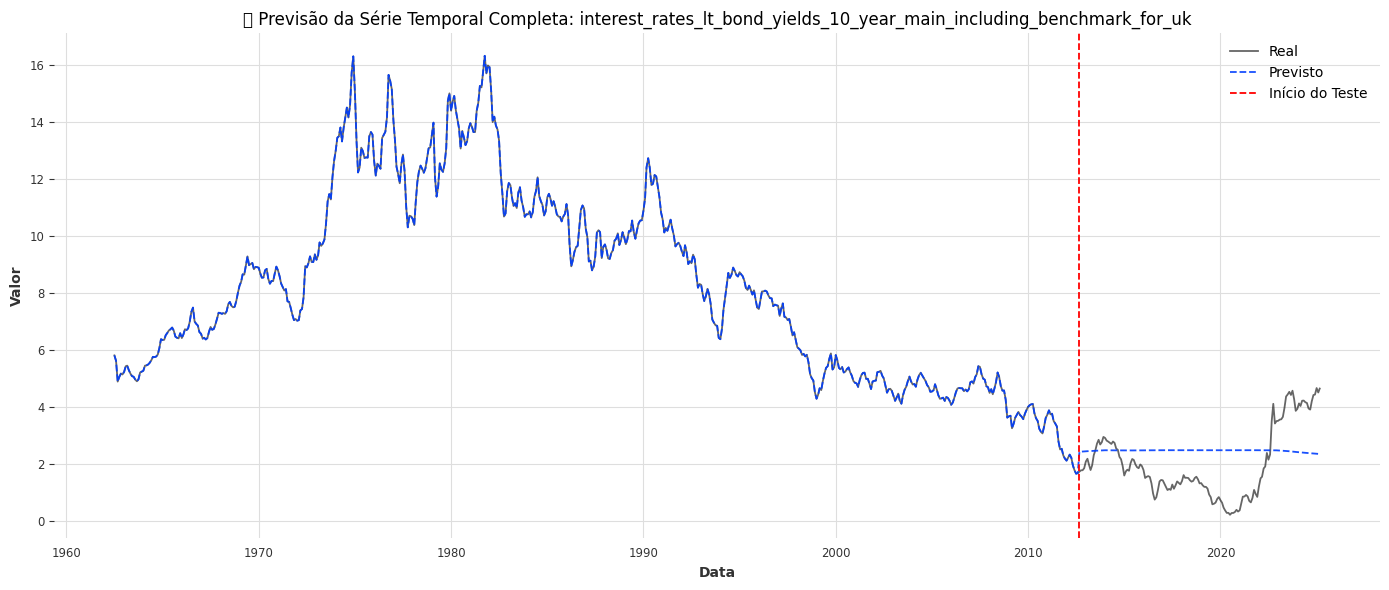


🔄 A treinar modelo para: house_prices_for_uk


c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
✅ MSE: 1686.4331 | MAE: 38.3141 | RMSE: 41.0662 | MAPE: 26.01%


C:\Users\diogo\AppData\Local\Temp\ipykernel_27328\729154498.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


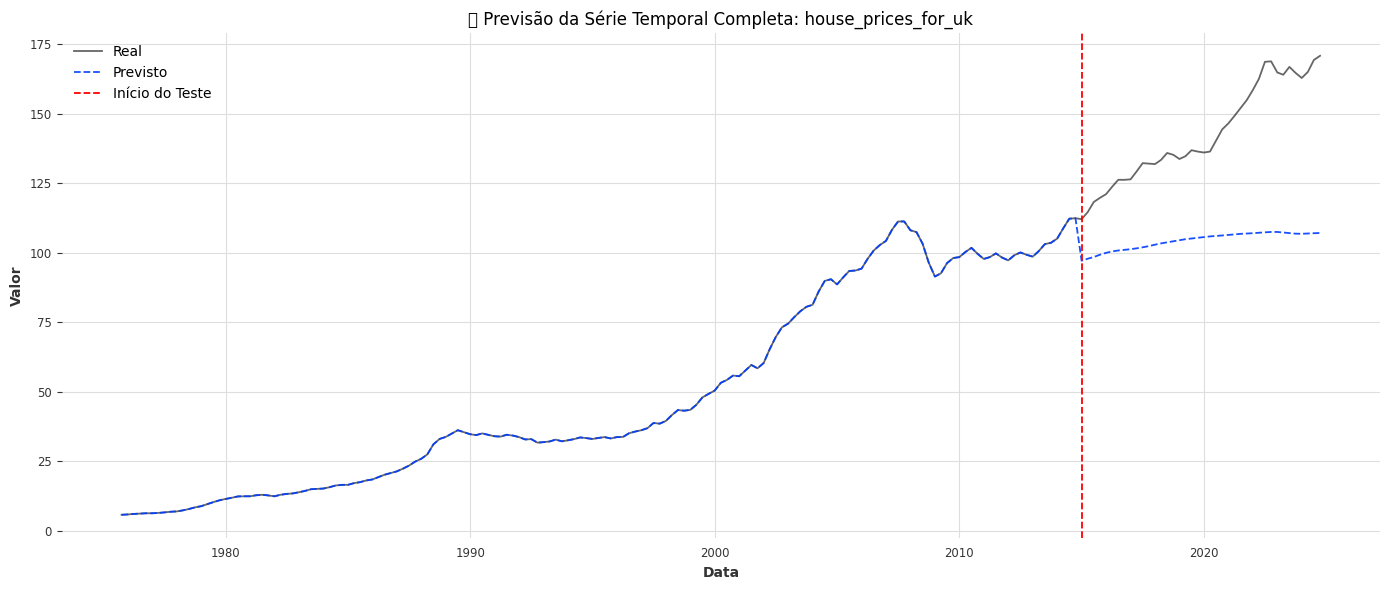


🔄 A treinar modelo para: gdp_for_uk


c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
✅ MSE: 21310353995.1556 | MAE: 131081.1056 | RMSE: 145980.6631 | MAPE: 22.82%


C:\Users\diogo\AppData\Local\Temp\ipykernel_27328\729154498.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


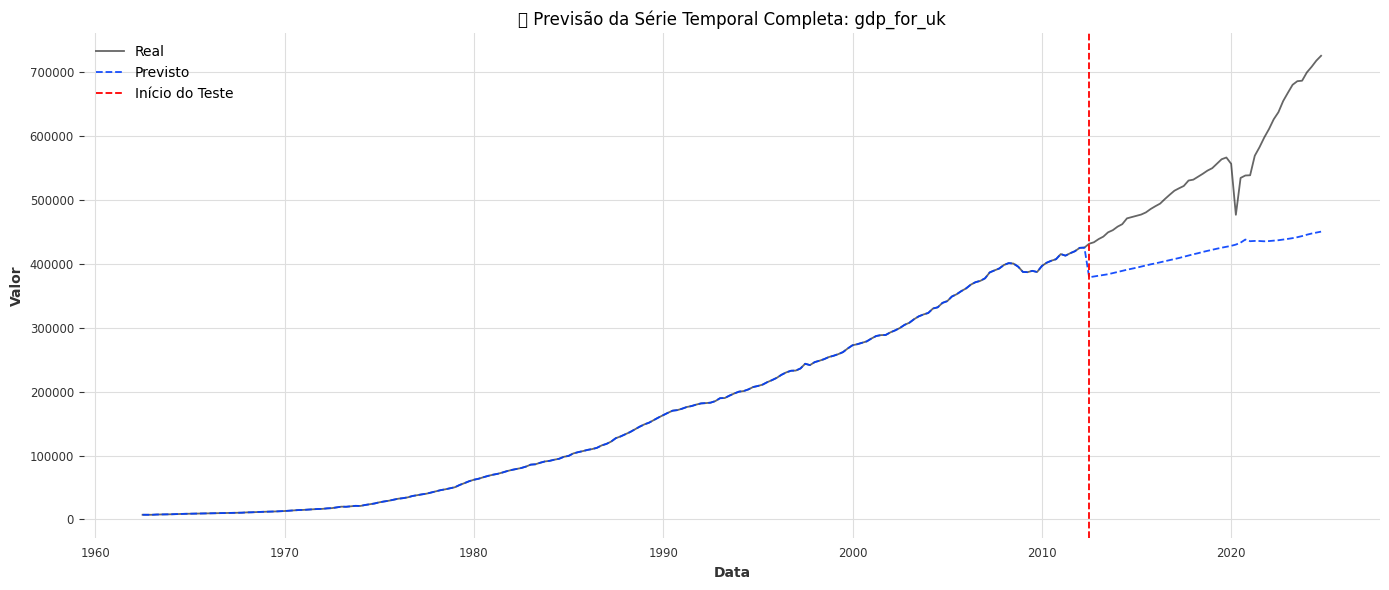


🔄 A treinar modelo para: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk


c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
✅ MSE: 11.6147 | MAE: 2.6082 | RMSE: 3.4080 | MAPE: 2.29%


C:\Users\diogo\AppData\Local\Temp\ipykernel_27328\729154498.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


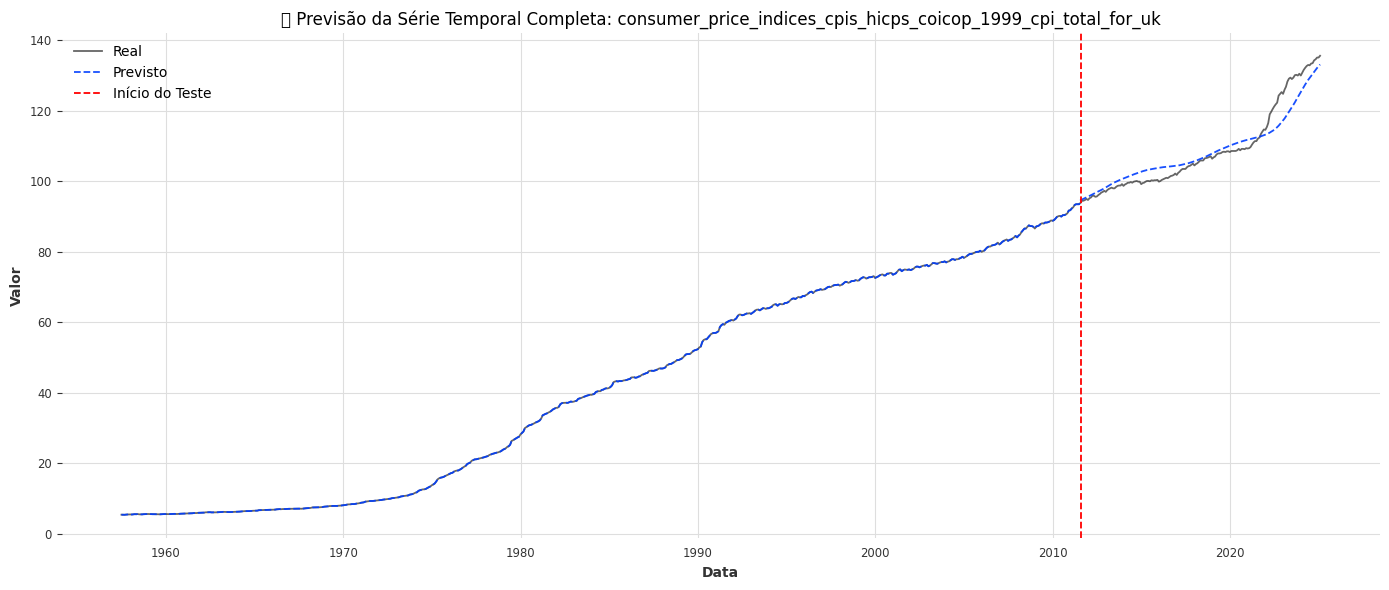

In [54]:
# Função para criar o modelo
def criar_modelo(seq_length):
    model = Sequential([
        Conv1D(filters=128, kernel_size=5, padding="same", input_shape=(seq_length, 1)),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),
        Dropout(0.3),
        
        Conv1D(filters=64, kernel_size=3, padding="same"),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),
        Dropout(0.3),
        
        Conv1D(filters=32, kernel_size=2, padding="same"),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),
        
        GlobalAveragePooling1D(),
        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),
        Dense(1)
    ])
    optimizer = Nadam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=Huber(delta=1.0), metrics=["mae", "mape", "mse"])
    return model


# Função para criar dados com janelas
def criar_janelas(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# Caminho para guardar modelos
os.makedirs("modelos", exist_ok=True)

# Iterar sobre todas as séries da FRED
for i, serie in enumerate(fred_series_list):
    nome_serie = serie.name.replace(" ", "_").replace("/", "_")
    print(f"\n🔄 A treinar modelo para: {nome_serie}")

    # Normalização e janelamento
    serie = serie.dropna()
    scaler = MinMaxScaler()
    serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1)).flatten()
    seq_length = 30
    X, y = criar_janelas(serie_scaled, seq_length)

    # Separar treino e teste (80/20)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshape para Conv1D
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Modelo
    model = criar_modelo(seq_length)

    # Callbacks
    checkpoint_path = f"modelos/best_model_{nome_serie}.h5"
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001, verbose=0)
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=0)
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S") + f"_{nome_serie}"
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Treino
    history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[reduce_lr, early_stopping, checkpoint, tensorboard],
                        verbose=0)

    # Carregar melhor modelo
    model.load_weights(checkpoint_path)
    y_pred = model.predict(X_test)

    # Reverter normalização
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    # Avaliação
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

    print(f"✅ MSE: {mse:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2%}")

    # Criar previsão completa (treino + teste)
    y_pred_full = np.concatenate([scaler.inverse_transform(y_train.reshape(-1, 1)), y_pred_inv])
    
    # Criar eixo temporal completo (excluindo os primeiros 'seq_length' pontos usados em janelas)
    datas_validas = serie.index[seq_length:]
    
    # Cortar série real também para ter a mesma dimensão
    serie_real = scaler.inverse_transform(serie_scaled[seq_length:].reshape(-1, 1))

    # Gráfico com série completa
    plt.figure(figsize=(14, 6))
    plt.plot(datas_validas, serie_real, label="Real", alpha=0.6)
    plt.plot(datas_validas, y_pred_full, label="Previsto", linestyle="dashed", alpha=0.9)
    plt.axvline(datas_validas[len(y_train)], color="red", linestyle="--", label="Início do Teste")
    plt.title(f"📈 Previsão da Série Temporal Completa: {serie.name}")
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [55]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)


🔄 A treinar modelo para: Job_Postings_on_Indeed_in_the_United_Kingdom


c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
✅ MSE: 147.3053 | MAE: 10.4330 | RMSE: 12.1369 | MAPE: 12.17%


C:\Users\diogo\AppData\Local\Temp\ipykernel_27328\3200383744.py:66: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


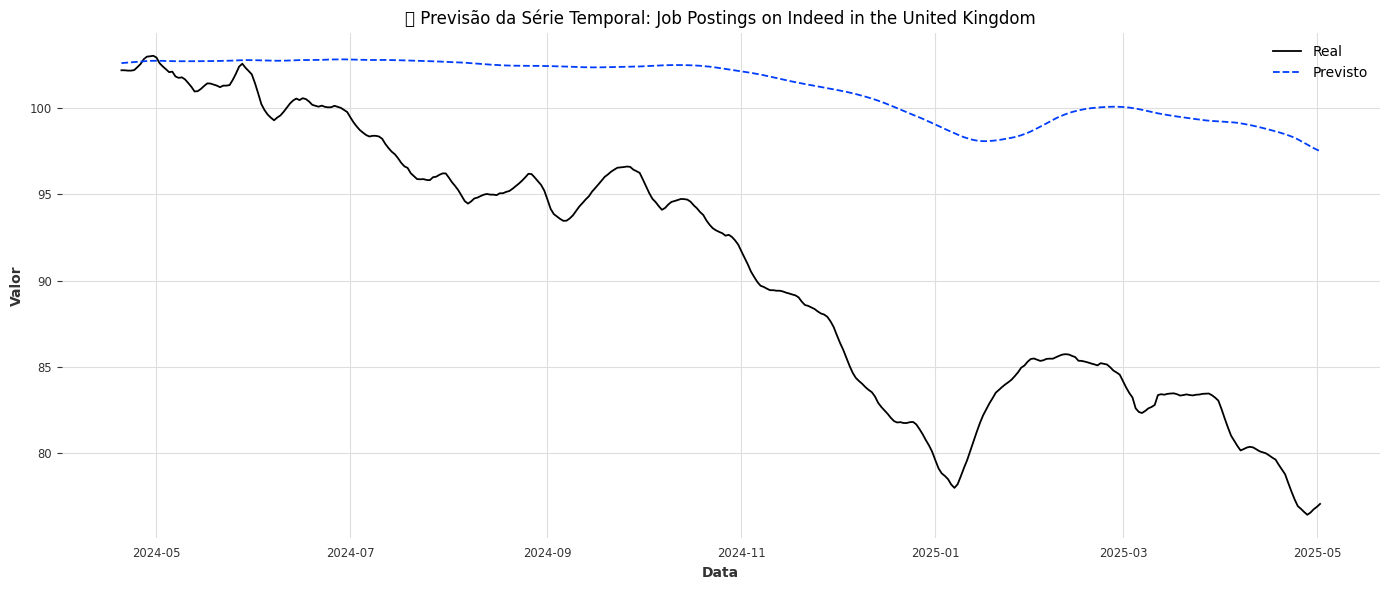


🔄 A treinar modelo para: Interest_Rates:_Long-Term_Government_Bond_Yields:_10-Year:_Main_(Including_Benchmark)_for_United_Kingdom


c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


InvalidArgumentError: {{function_node __wrapped__CreateSummaryFileWriter_device_/job:localhost/replica:0/task:0/device:CPU:0}} Failed to create a directory: logs/fit/20250509-160201_Interest_Rates:_Long-Term_Government_Bond_Yields:_10-Year:_Main_(Including_Benchmark)_for_United_Kingdom; Invalid argument [Op:CreateSummaryFileWriter] name: 

In [ ]:
# Caminho para guardar modelos
os.makedirs("modelos", exist_ok=True)

# Iterar sobre todas as séries da FRED
for i, serie in enumerate(fred_series_list):
    nome_serie = serie.name.replace(" ", "_").replace("/", "_")
    print(f"\n🔄 A treinar modelo para: {nome_serie}")

    # Normalização e janelamento
    serie = serie.dropna()
    scaler = MinMaxScaler()
    serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1)).flatten()
    seq_length = 30
    X, y = criar_janelas(serie_scaled, seq_length)

    # Separar treino e teste (80/20)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshape para Conv1D
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Modelo
    model = criar_modelo(seq_length)

    # Callbacks
    checkpoint_path = f"modelos/best_model_{nome_serie}.h5"
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001, verbose=0)
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=0)
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S") + f"_{nome_serie}"
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Treino
    history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[reduce_lr, early_stopping, checkpoint, tensorboard],
                        verbose=0)

    # Carregar melhor modelo
    model.load_weights(checkpoint_path)
    y_pred = model.predict(X_test)

    # Reverter normalização
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    # Avaliação
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

    print(f"✅ MSE: {mse:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2%}")

    # Gráficos
    plt.figure(figsize=(14, 6))
    plt.plot(serie.index[-len(y_test):], y_test_inv, label="Real")
    plt.plot(serie.index[-len(y_test):], y_pred_inv, label="Previsto", linestyle="dashed")
    plt.legend()
    plt.title(f"📈 Previsão da Série Temporal: {serie.name}")
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.tight_layout()
    plt.show()

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation="relu", padding="same", input_shape=(seq_length, 1)),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=3, activation="relu", padding="same"),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

# Otimizador Adam com ReduceLROnPlateau para diminuir o learning rate automaticamente
optimizer = AdamW(learning_rate=0.001, weight_decay=0.01)

## Callbacks ##
# Callback para reduzir o learning rate se a validação parar de melhorar
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001, verbose=1)

# Callback para parar o treino cedo se a validação não melhorar por 10 épocas
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Callback para guardar o melhor modelo durante o treino
checkpoint = ModelCheckpoint("1", monitor="val_loss", save_best_only=True, verbose=1)

# Callback para visualizar métricas no TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Treinar a CNN

In [ ]:
# Lista final de callbacks
callbacks = [reduce_lr, early_stopping, checkpoint, tensorboard]

# Treinar o modelo com os callbacks
model.compile(optimizer=optimizer, loss=Huber(delta=1.0), metrics=["mae", "mape", "mse"])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
224/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1082 - mae: 0.3043 - mape: 1642.8292 - mse: 0.2433
Epoch 1: val_loss improved from inf to 0.01103, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1061 - mae: 0.2998 - mape: 1635.5653 - mse: 0.2385 - val_loss: 0.0110 - val_mae: 0.1016 - val_mape: 75.2089 - val_mse: 0.0221 - learning_rate: 0.0010
Epoch 2/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mae: 0.0502 - mape: 470.4317 - mse: 0.0052
Epoch 2: val_loss improved from 0.01103 to 0.00870, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0026 - mae: 0.0501 - mape: 476.2282 - mse: 0.0052 - val_loss: 0.0087 - val_mae: 0.0895 - val_mape: 60.7749 - val_mse: 0.0174 - learning_rate: 0.0010
Epoch 3/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0409 - mape: 1388.9742 - mse: 0.0032
Epoch 3: val_loss improved from 0.00870 to 0.00816, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016 - mae: 0.0409 - mape: 1476.0780 - mse: 0.0032 - val_loss: 0.0082 - val_mae: 0.0776 - val_mape: 53.1113 - val_mse: 0.0164 - learning_rate: 0.0010
Epoch 4/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0392 - mape: 67.9766 - mse: 0.0031
Epoch 4: val_loss improved from 0.00816 to 0.00652, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016 - mae: 0.0392 - mape: 292.5132 - mse: 0.0031 - val_loss: 0.0065 - val_mae: 0.0676 - val_mape: 56.9699 - val_mse: 0.0132 - learning_rate: 0.0010
Epoch 5/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mae: 0.0387 - mape: 25769.7812 - mse: 0.0030
Epoch 5: val_loss did not improve from 0.00652
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0015 - mae: 0.0387 - mape: 25633.5293 - mse: 0.0030 - val_loss: 0.0076 - val_mae: 0.0736 - val_mape: 52.7445 - val_mse: 0.0154 - learning_rate: 0.0010
Epoch 6/100
225/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0383 - mape: 5234.8359 - mse: 0.0029
Epoch 6: val_loss did not improve from 0.00652
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0383 - mape: 5346.1597 - mse: 0.0029 - val_loss: 0.0079 - val_mae: 0.0750 - val_mape: 52.8578 - val_mse: 0.0160 - learning_rate: 0.0010
Epoch 7/100
224/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae:

230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016 - mae: 0.0387 - mape: 6341.5894 - mse: 0.0032 - val_loss: 0.0060 - val_mae: 0.0633 - val_mape: 47.7190 - val_mse: 0.0122 - learning_rate: 0.0010
Epoch 9/100
225/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0371 - mape: 12805.2432 - mse: 0.0029
Epoch 9: val_loss did not improve from 0.00604
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0371 - mape: 12725.3232 - mse: 0.0029 - val_loss: 0.0073 - val_mae: 0.0721 - val_mape: 50.2782 - val_mse: 0.0148 - learning_rate: 0.0010
Epoch 10/100
225/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0364 - mape: 656.0209 - mse: 0.0026
Epoch 10: val_loss improved from 0.00604 to 0.00595, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0364 - mape: 662.0577 - mse: 0.0026 - val_loss: 0.0059 - val_mae: 0.0655 - val_mape: 47.0781 - val_mse: 0.0120 - learning_rate: 0.0010
Epoch 11/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0366 - mape: 1643.9930 - mse: 0.0027
Epoch 11: val_loss improved from 0.00595 to 0.00505, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014 - mae: 0.0366 - mape: 1663.8480 - mse: 0.0027 - val_loss: 0.0050 - val_mae: 0.0623 - val_mape: 49.3936 - val_mse: 0.0102 - learning_rate: 0.0010
Epoch 12/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0364 - mape: 955.9527 - mse: 0.0027
Epoch 12: val_loss did not improve from 0.00505
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0364 - mape: 978.9586 - mse: 0.0027 - val_loss: 0.0057 - val_mae: 0.0629 - val_mape: 49.0724 - val_mse: 0.0119 - learning_rate: 0.0010
Epoch 13/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0359 - mape: 15718.5586 - mse: 0.0027
Epoch 13: val_loss did not improve from 0.00505
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0360 - mape: 15602.8447 - mse: 0.0027 - val_loss: 0.0060 - val_mae: 0.0638 - val_mape: 47.7136 - val_mse: 0.0121 - learning_rate: 0.0010
Epoch 14/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 -

230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0374 - mape: 2351.0854 - mse: 0.0028 - val_loss: 0.0047 - val_mae: 0.0613 - val_mape: 48.2072 - val_mse: 0.0095 - learning_rate: 0.0010
Epoch 17/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - mae: 0.0364 - mape: 665.5015 - mse: 0.0026
Epoch 17: val_loss did not improve from 0.00475
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0364 - mape: 797.3800 - mse: 0.0026 - val_loss: 0.0048 - val_mae: 0.0609 - val_mape: 48.4791 - val_mse: 0.0097 - learning_rate: 0.0010
Epoch 18/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0361 - mape: 25912.8379 - mse: 0.0026
Epoch 18: val_loss did not improve from 0.00475
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0361 - mape: 25649.6484 - mse: 0.0026 - val_loss: 0.0068 - val_mae: 0.0728 - val_mape: 50.3334 - val_mse: 0.0137 - learning_rate: 0.0010
Epoch 19/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - 

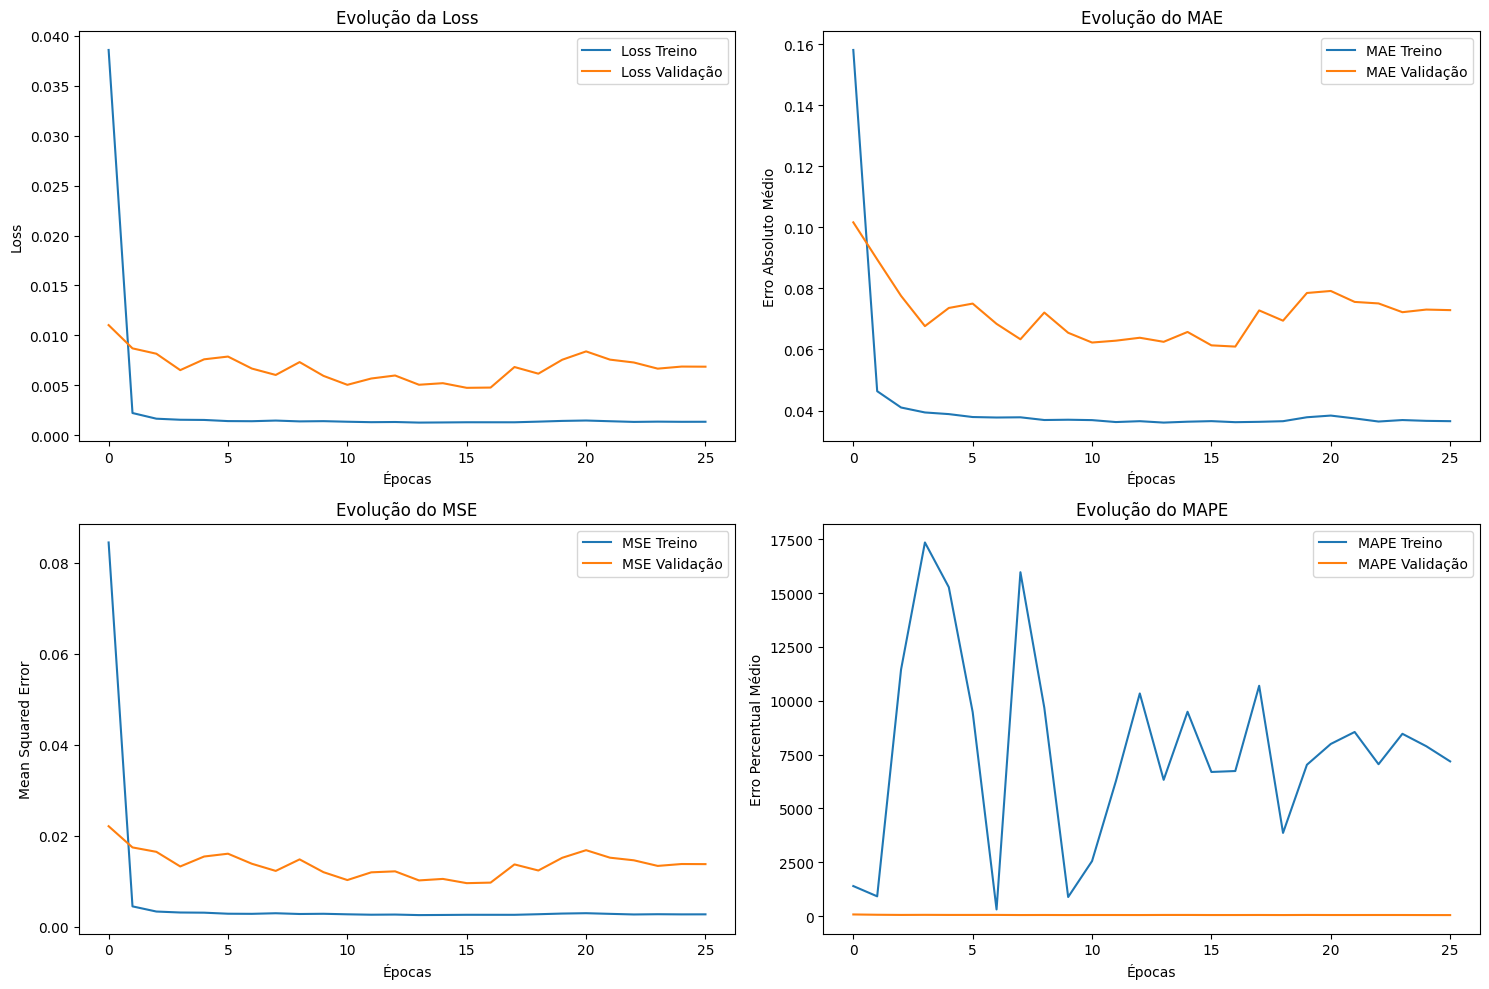

In [ ]:
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history["loss"], label="Loss Treino")
plt.plot(history.history["val_loss"], label="Loss Validação")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.title("Evolução da Loss")

# MAE
plt.subplot(2, 2, 2)
plt.plot(history.history["mae"], label="MAE Treino")
plt.plot(history.history["val_mae"], label="MAE Validação")
plt.xlabel("Épocas")
plt.ylabel("Erro Absoluto Médio")
plt.legend()
plt.title("Evolução do MAE")

# MSE
plt.subplot(2, 2, 3)
plt.plot(history.history["mse"], label="MSE Treino")
plt.plot(history.history["val_mse"], label="MSE Validação")
plt.xlabel("Épocas")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("Evolução do MSE")

# MAPE
plt.subplot(2, 2, 4)
plt.plot(history.history["mape"], label="MAPE Treino")
plt.plot(history.history["val_mape"], label="MAPE Validação")
plt.xlabel("Épocas")
plt.ylabel("Erro Percentual Médio")
plt.legend()
plt.title("Evolução do MAPE")

plt.tight_layout()
plt.show()

In [ ]:
# Carregar os pesos do arquivo best_model.h5
model.load_weights('best_model.h5')

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Reverter normalização
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Calcular métricas finais
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print(f"📊 Avaliação do Modelo:")
print(f"✅ MSE: {mse:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAPE: {mape:.2%}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
📊 Avaliação do Modelo:
✅ MSE: 9995.3636
✅ MAE: 62.7619
✅ RMSE: 99.9768
✅ MAPE: 45.85%


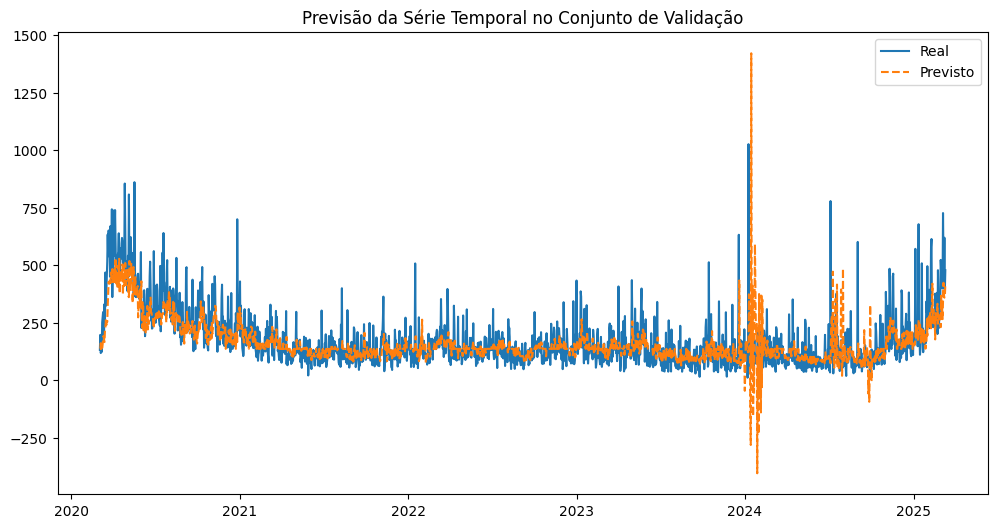

In [ ]:
# Visualizar apenas conjunto de teste
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label="Real")
plt.plot(df.index[-len(y_test):], y_pred_inv, label="Previsto", linestyle="dashed")
plt.legend()
plt.title("Previsão da Série Temporal no Conjunto de Validação")
plt.show()

#### Fazer previsões

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

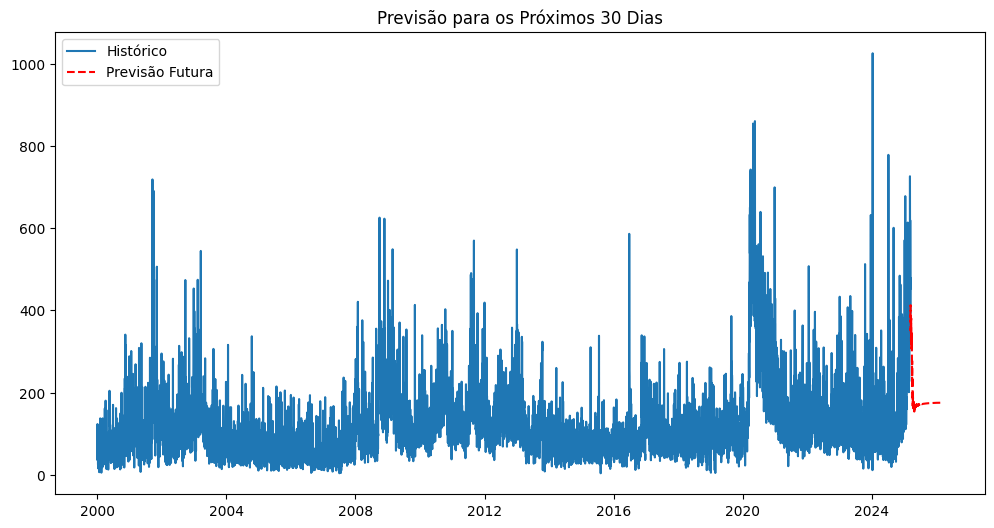

In [ ]:
def forecast_future(model, data, days, seq_length):
    last_seq = data[-seq_length:]  # Últimos `seq_length` valores como entrada
    predictions = []

    for _ in range(days):
        pred = model.predict(last_seq.reshape(1, seq_length, 1))[0, 0]  # Fazer previsão
        predictions.append(pred)
        last_seq = np.roll(last_seq, -1)  # Deslocar a sequência para frente
        last_seq[-1] = pred  # Adicionar a nova previsão

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

dias = 365

# Fazer previsão para os próximos 30 dias
future_pred = forecast_future(model, df_scaled, days=dias, seq_length=seq_length)

# Criar datas futuras
future_dates = pd.date_range(start=df.index[-1], periods=dias, freq="D")

# Visualizar previsão futura
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaler.inverse_transform(df_scaled), label="Histórico")
plt.plot(future_dates, future_pred, label="Previsão Futura", linestyle="dashed", color="red")
plt.legend()
plt.title(f"Previsão para os Próximos {dias} Dias")
plt.show()

### PyTorch